# Adversarial Attack Project (FGSM + PGD)
This notebook contains full runnable code for training a CNN on CIFAR-10
and generating FGSM and PGD adversarial attacks.

Torch version: 2.9.1+cu128
Torchvision version: 0.24.1+cu128
CUDA available: True
Using device: cuda
Training model...
Epoch 1/3 completed
Epoch 2/3 completed
Epoch 3/3 completed

Running FGSM attack...

=== FGSM RESULTS ===
Clean Accuracy : 0.4709
Adv Accuracy   : 0.1014
ASR            : 0.7846676576767891

Running PGD attack...

=== PGD RESULTS ===
Clean Accuracy : 0.4709
Adv Accuracy   : 0.0752
ASR            : 0.8403057974092164

Showing sample FGSM images:


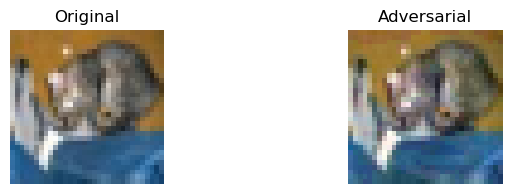


Showing sample PGD images:


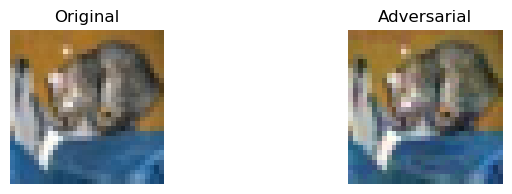


Done!


In [8]:
# ============================================================
#   ADVERSARIAL ATTACK PROJECT - FULL COLAB NOTEBOOK IN ONE CELL
#   FGSM + PGD Attacks on CIFAR-10 using a CNN
# ============================================================

!pip install torch torchvision matplotlib pillow 

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------------------
# 1. SIMPLE CNN MODEL
# ------------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2,2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*8*8, 256), nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

# ------------------------------
# 2. FGSM ATTACK
# ------------------------------
def fgsm_attack(model, loss_fn, images, labels, epsilon):
    images = images.clone().detach().to(device)
    images.requires_grad = True

    outputs = model(images)
    loss = loss_fn(outputs, labels)
    model.zero_grad()
    loss.backward()

    adv = images + epsilon * images.grad.sign()
    return torch.clamp(adv, 0, 1)

# ------------------------------
# 3. PGD ATTACK
# ------------------------------
def pgd_attack(model, loss_fn, images, labels, epsilon, alpha, iters):
    ori = images.clone().detach().to(device)
    adv = ori.clone().detach()

    for i in range(iters):
        adv.requires_grad = True
        outputs = model(adv)
        loss = loss_fn(outputs, labels)

        model.zero_grad()
        loss.backward()

        adv = adv + alpha * adv.grad.sign()
        eta = torch.clamp(adv - ori, -epsilon, epsilon)
        adv = torch.clamp(ori + eta, 0, 1).detach()

    return adv

# ------------------------------
# 4. LOAD DATA
# ------------------------------
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor()
])

transform_test = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
testset  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader  = DataLoader(testset,  batch_size=128, shuffle=False)

# ------------------------------
# 5. TRAIN MODEL
# ------------------------------
model = SimpleCNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

print("Training model...")
for epoch in range(3):   # change to more epochs if needed
    model.train()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/3 completed")

# Save model
os.makedirs("checkpoints", exist_ok=True)
torch.save(model.state_dict(), "checkpoints/cnn.pth")

# ------------------------------
# 6. EVALUATE + ATTACK + ASR
# ------------------------------
def evaluate_attack(attack_name, adv_images):
    model.eval()
    clean_correct, adv_correct = 0, 0
    orig_correct, became_wrong = 0, 0

    j = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        # Clean preds
        out_clean = model(images)
        _, pred_clean = out_clean.max(1)

        # Adv preds
        out_adv = model(adv_images[j:j+len(images)])
        _, pred_adv = out_adv.max(1)

        clean_correct += pred_clean.eq(labels).sum().item()
        adv_correct += pred_adv.eq(labels).sum().item()

        for i in range(len(labels)):
            if pred_clean[i] == labels[i]:
                orig_correct += 1
                if pred_adv[i] != labels[i]:
                    became_wrong += 1

        j += len(images)

    clean_acc = clean_correct / len(testset)
    adv_acc = adv_correct / len(testset)
    asr = became_wrong / orig_correct

    print(f"\n=== {attack_name} RESULTS ===")
    print("Clean Accuracy :", clean_acc)
    print("Adv Accuracy   :", adv_acc)
    print("ASR            :", asr)

# ------------------------------
# 7. RUN FGSM
# ------------------------------
epsilon = 0.03
adv_images_fgsm = []

print("\nRunning FGSM attack...")
for images, labels in testloader:
    adv = fgsm_attack(model, loss_fn, images.to(device), labels.to(device), epsilon)
    adv_images_fgsm.append(adv)

adv_images_fgsm = torch.cat(adv_images_fgsm)
evaluate_attack("FGSM", adv_images_fgsm)

# ------------------------------
# 8. RUN PGD
# ------------------------------
epsilon = 0.03
alpha = 0.007
iters = 20

adv_images_pgd = []

print("\nRunning PGD attack...")
for images, labels in testloader:
    adv = pgd_attack(model, loss_fn, images.to(device), labels.to(device), epsilon, alpha, iters)
    adv_images_pgd.append(adv)

adv_images_pgd = torch.cat(adv_images_pgd)
evaluate_attack("PGD", adv_images_pgd)
# ------------------------------
# 9. SHOW SAMPLE IMAGES
# ------------------------------


def show_images(original, adversarial, n=5):
    plt.figure(figsize=(8, n*2))
    for i in range(n):
        plt.subplot(n, 2, 2*i+1)
        # plt.imshow(original[i].permute(1,2,0).cpu())
        plt.imshow(original[i].detach().permute(1,2,0).cpu())
        plt.title("Original")
        plt.axis("off")

        plt.subplot(n, 2, 2*i+2)
        # plt.imshow(adversarial[i].permute(1,2,0).cpu())
        plt.imshow(adversarial[i].detach().permute(1,2,0).cpu())

        plt.title("Adversarial")
        plt.axis("off")
    plt.show()

print("\nShowing sample FGSM images:")
# show_images(testset[0][0].unsqueeze(0), adv_images_fgsm[0:1])
show_images(testset[0][0].unsqueeze(0), adv_images_fgsm[0:1], n=1)

print("\nShowing sample PGD images:")
# show_images(testset[0][0].unsqueeze(0), adv_images_pgd[0:1])
show_images(testset[0][0].unsqueeze(0), adv_images_pgd[0:1], n=1)

print("\nDone!")
